In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import numpy as np
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap, Normalize

In [2]:
# Shapefile
taz_shp_path = 'H:/shaked-unzip/Shaked_shp/TAZold_TLVcity_clean.shp'
# Load data
spreadsheet = 'H:/shaked-unzip/aas_1.06.csv'
df = pd.read_csv(spreadsheet)

C:\Users\noamgal3\AppData\Local\Temp\ipykernel_12980\2262463483.py:5: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(spreadsheet)


In [3]:
# Data cleaning

# Strip empty spaces from column names
df.columns = df.columns.str.strip()

# Replace '--' with 0 in the 'Mode' column and fill NaN values with -1 in TAZ columns
df['Mode'] = df['Mode'].replace('--', '0')
df['NewTazSource'] = df['NewTazSource'].fillna(-1)
df['NewTaz'] = df['NewTaz'].fillna(-1)

# Convert columns to appropriate data types
df['Mode'] = pd.to_numeric(df['Mode'], errors='coerce')
df['NewTazSource'] = pd.to_numeric(df['NewTazSource'], errors='coerce')
df['NewTaz'] = pd.to_numeric(df['NewTaz'], errors='coerce')

In [4]:
# Replace the integer keys in the dataframe with their values

# Dictionary for interpreting modes
mode_code_dict = {
    0: 'Not Available', 1: 'walk', 2: 'bicycles', 3: 'bus', 4: 'service taxi',
    5: 'special taxi', 6: 'train', 7: 'driving a car', 8: 'passengers in a car',
    9: 'motorcycle/scooter', 10: 'Organized transportation', 11: 'other',
    33: 'unknown bus type', 45: 'unknown taxi type',
    98: 'not applicable', 99: 'unknown'
}

# Dictionary for interpreting activities
activity_code_dict = {
    1: 'house', 2: 'work', 3: 'studies', 4: 'shopping', 5: 'work related',
    6: 'Personal', 7: 'Social Visit', 8: 'health services',
    9: 'Entertainment', 10: 'sports activity',
    11: 'Drop off/pick up', 12: 'other', 99: 'unknown'
}

# Assuming df is your original DataFrame
activity_v_mode = df[['Mode', 'mainActivity']].copy()
# Map the dictionaries to replace numbers with labels
activity_v_mode['Mode'] = activity_v_mode['Mode'].map(mode_code_dict)
activity_v_mode['mainActivity'] = activity_v_mode['mainActivity'].map(activity_code_dict)

In [5]:
# Dictionary for merging modes
merged_modes = {
    'Not Available': 'unknown',
    'not applicable': 'unknown',
    'other': 'unknown',
    'unknown': 'unknown',
    'motorcycle/scooter': 'two-wheels',
    'bicycles': 'two-wheels',
    'driving a car': 'driving',
    'passengers in a car': 'driving',
    'service taxi': 'taxi',
    'special taxi': 'taxi',
    'unknown taxi type': 'taxi',
    'Organized transportation' : 'Mass transit',
    'bus' :  'Mass transit',
    'unknown bus type': 'Mass transit',
    'train': 'Mass transit',
    
}

# Define a function to merge categories
def merge_mode_categories(category):
    if category in merged_modes:
        return merged_modes[category]
    else:
        return category

# Apply the merge function to the 'Mode' column
activity_v_mode['Mode'] = activity_v_mode['Mode'].apply(merge_mode_categories)
activity_v_mode.fillna('unknown', inplace=True)
# Display the new DataFrame
print(activity_v_mode)

# Print remaining unique categories
print("\nRemaining unique categories:")
print(activity_v_mode['Mode'].unique())

              Mode mainActivity
0          unknown      unknown
1             walk      studies
2             walk        house
3       two-wheels      studies
4       two-wheels        house
...            ...          ...
333719     driving      studies
333720     driving        house
333721     unknown      unknown
333722     driving      studies
333723     driving        house

[333724 rows x 2 columns]

Remaining unique categories:
['unknown' 'walk' 'two-wheels' 'Mass transit' 'driving' 'taxi']


C:\Users\noamgal3\AppData\Local\Temp\ipykernel_12980\1392080145.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set3').colors


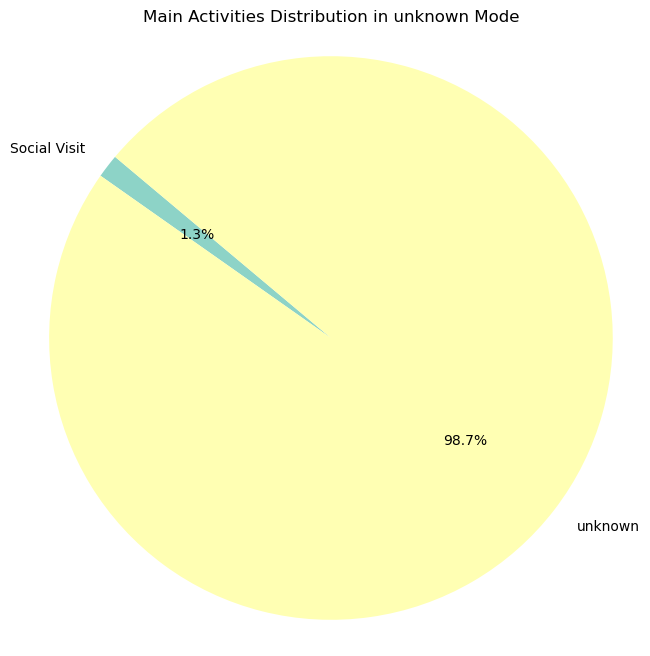

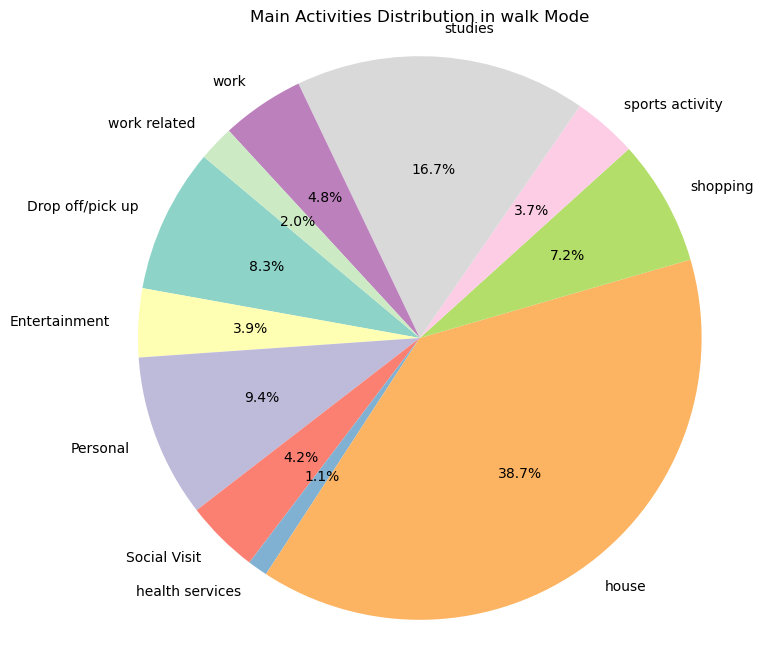

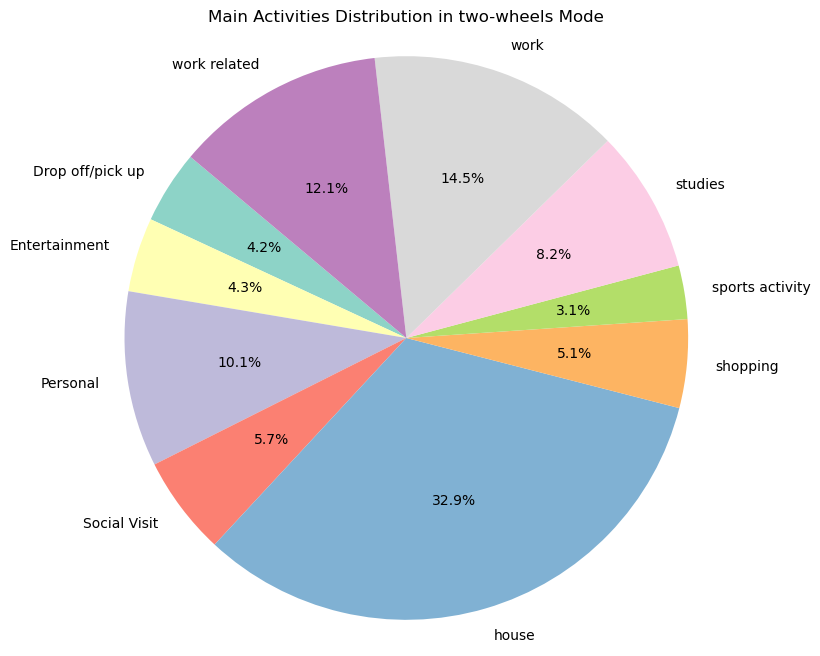

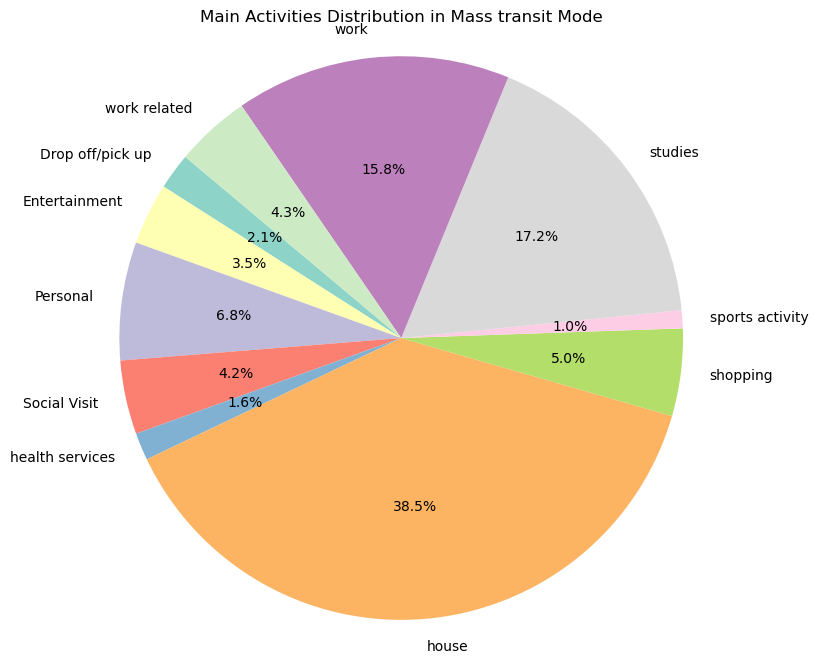

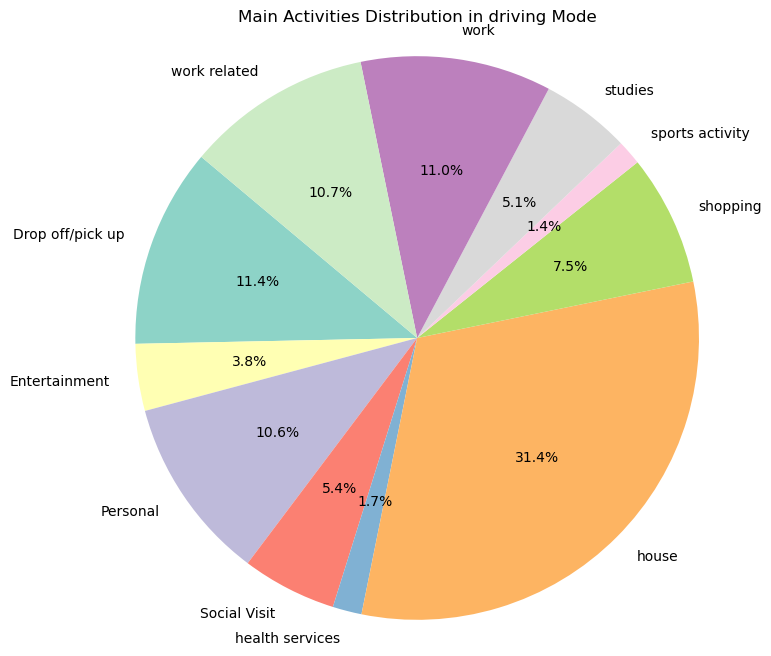

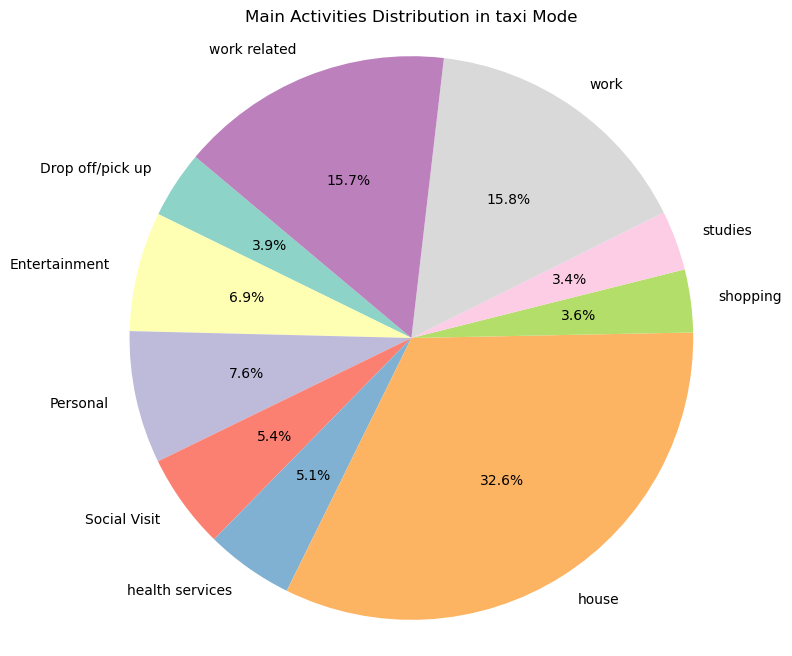

In [6]:
grouped_data = activity_v_mode.groupby(['Mode', 'mainActivity']).size().reset_index(name='count')


# Define a colormap
colors = plt.cm.get_cmap('Set3').colors

# Filter the data for each transport mode and plot pie charts
for i, mode in enumerate(activity_v_mode['Mode'].unique()):
    # Filter data for the current mode
    mode_data = grouped_data[grouped_data['Mode'] == mode]
    
    # Calculate total count for the mode
    total_count = mode_data['count'].sum()
    
    # Filter main activities that account for more than 1% of the total count
    filtered_data = mode_data[mode_data['count'] / total_count > 0.01]
    
    # Check if there is data available for plotting
    if not filtered_data.empty:
        plt.figure(figsize=(8, 8))
        plt.pie(filtered_data['count'], labels=filtered_data['mainActivity'], autopct='%1.1f%%', startangle=140, colors=colors)
        plt.title(f'Main Activities Distribution in {mode} Mode')
        plt.axis('equal')
        plt.show()
    else:
        print(f"No data available for plotting for '{mode}' mode.")

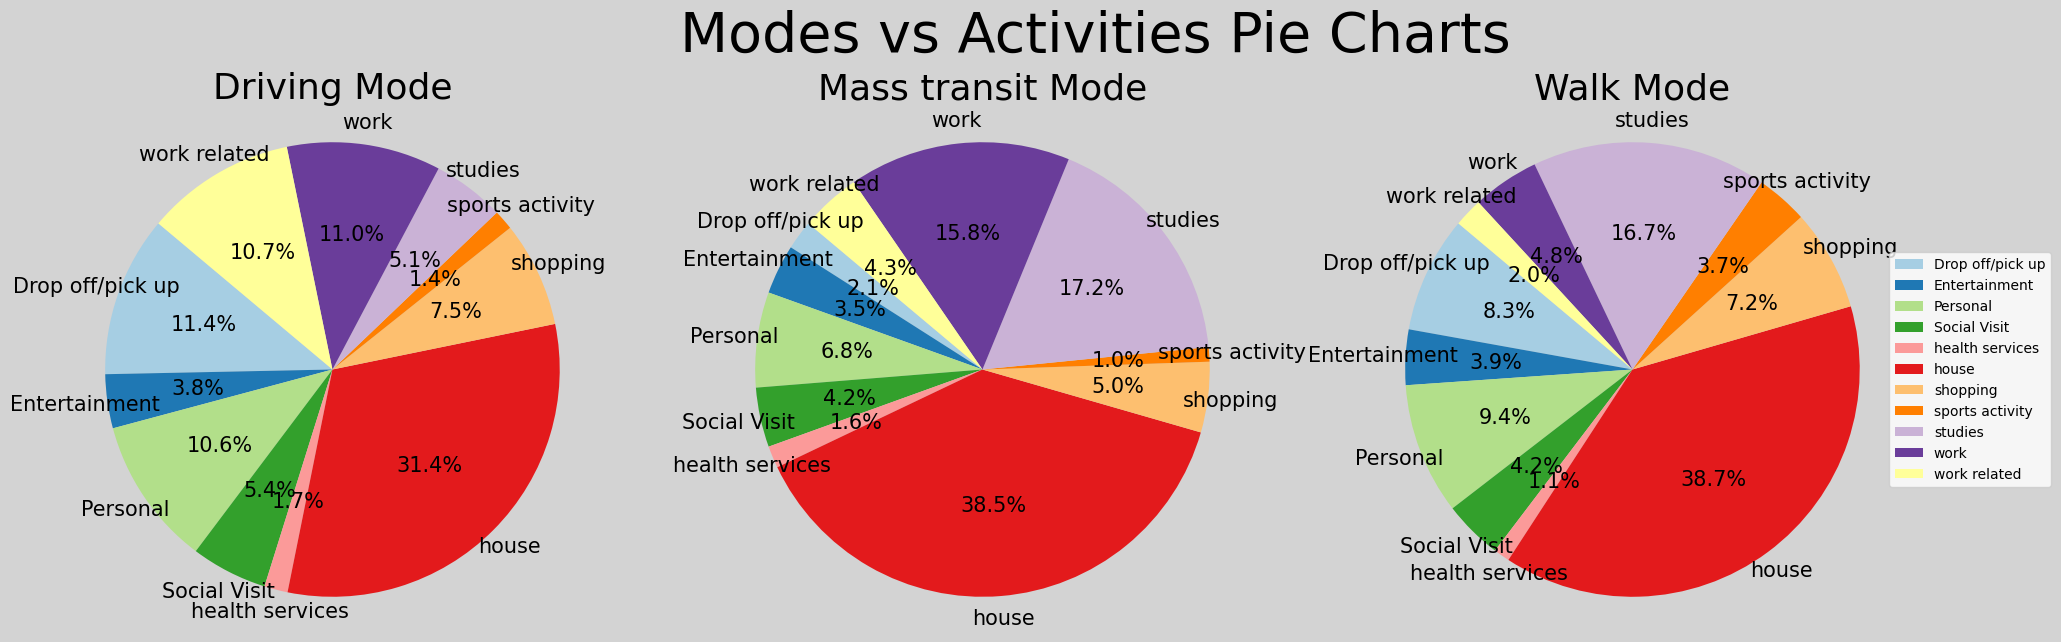

In [10]:

# Define colors for the pie charts
num_categories = len(grouped_data['mainActivity'].unique())
colors = sns.color_palette('Paired', num_categories)

# Filter the data for driving, mass transit, and walking modes
selected_modes = ['driving', 'Mass transit', 'walk']
filtered_data = grouped_data[grouped_data['Mode'].isin(selected_modes)]

# Create subplots for the pie charts
fig, axes = plt.subplots(1, len(selected_modes), figsize=(22.5, 7.5), facecolor='lightgrey')

# Plot pie charts for each mode with doubled font size
for i, mode in enumerate(selected_modes):
    mode_data = filtered_data[filtered_data['Mode'] == mode]
    total_count = mode_data['count'].sum()
    filtered_data_mode = mode_data[mode_data['count'] / total_count > 0.01]
    
    # Plot pie chart for the current mode with doubled font size
    wedges, texts, autotexts = axes[i].pie(filtered_data_mode['count'], labels=filtered_data_mode['mainActivity'], autopct='%1.1f%%', startangle=140, colors=colors, textprops={'fontsize': 15})
    axes[i].set_title(f'{mode.capitalize()} Mode', fontsize=26)
    axes[i].axis('equal')
    
    # Ensure no text overlaps
    for text in texts:
        text.set_horizontalalignment('center')

# Create a legend for the entire plot
plt.legend(filtered_data_mode['mainActivity'], loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Create a title for the entire plot with increased font size
plt.suptitle('Modes vs Activities Pie Charts', fontsize=40)

# Manually adjust layout
plt.subplots_adjust(left=0.05, right=0.85, top=0.85, bottom=0.15, wspace=0.3)

# Show the plot
plt.show()

In [9]:
# Define the file name for saving
file_name = "H:\modes_vs_activities_pie_charts_big_text.jpg"

# Save the plot as a JPEG file with 1080p resolution
fig.savefig(file_name, dpi=200)

# Provide feedback
print(f"The plot has been saved as '{file_name}' with 1080p resolution.")


The plot has been saved as 'H:\modes_vs_activities_pie_charts_big_text.jpg' with 1080p resolution.
